# |In this notebook we fit a SEIR model to the Moscow Covid-19 data

In [119]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit
from tqdm.auto import tqdm
from copy import deepcopy

In [120]:
sns.set()
%matplotlib inline

In [121]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [122]:
%autoreload 2

In [123]:
from sir_models.seir import SEIR, CurveFitter
from sir_models.utils import stepwise, compute_daily_values, eval_one_day_ahead

# Load data

In [124]:
DATASET_PATH = '/media/boris/ubuntu_data/datasets/covid-19-data/public/data/owid-covid-data.csv'
df = pd.read_csv(DATASET_PATH)

In [125]:

useless_columns = ['iso_code', 'continent',
       'new_vaccinations_smoothed', 'total_vaccinations_per_hundred',
       'people_vaccinated_per_hundred', 'people_fully_vaccinated_per_hundred',
       'new_vaccinations_smoothed_per_million', 'stringency_index',
       'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index', 'total_cases_per_million', 'new_cases_per_million',
       'new_cases_smoothed_per_million', 'total_deaths_per_million',
       'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'icu_patients_per_million', 'hosp_patients_per_million', 'weekly_icu_admissions_per_million',
        'weekly_hosp_admissions_per_million', 'total_tests_per_thousand',  'new_tests_per_thousand', 'new_tests_smoothed_per_thousand', 'icu_patients', 'hosp_patients',
       'weekly_icu_admissions', 'weekly_hosp_admissions',
                   'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'new_vaccinations',
                  ]
df = df.drop(columns=useless_columns)
df.date = pd.to_datetime(df.date)

df = df[df.location == 'Russia']

df['total_deaths'] = df.total_deaths.fillna(0)
df['new_deaths'] = df.new_deaths.fillna(0)
df.head().T

,52406,52407,52408,52409,52410
location,Russia,Russia,Russia,Russia,Russia
date,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00
total_cases,2,2,2,2,2
new_cases,2,0,0,0,0
new_cases_smoothed,NaN,NaN,NaN,NaN,NaN
total_deaths,0,0,0,0,0
new_deaths,0,0,0,0,0
new_deaths_smoothed,NaN,NaN,NaN,NaN,NaN
reproduction_rate,NaN,NaN,NaN,NaN,NaN
new_tests,NaN,NaN,NaN,NaN,NaN


# Define model and fitter

In [151]:
class SEIR_OWID(SEIR):
    def get_fit_params(self, data):
        params = lmfit.Parameters()
        # Non-variable
        params.add("base_population", value=df.iloc[0].population, vary=False)
        params.add("pre_existing_immunity", value=0.1806, vary=False)
        params.add("sus_population", expr='base_population - base_population * pre_existing_immunity', vary=False)

        params.add("r0", value=3.5, min=2.5, max=4, vary=True)
        params.add("rho", value=1 / 14, min=1/20, max=1/7, vary=True)  # I -> D rate
        params.add("alpha", value=0.0066, min=0.0001, max=0.05, vary=True) # Probability to die if infected
        
        params.add("sigmoid_r", value=20, min=1, max=30, vary=False)
        params.add("sigmoid_c", value=0.5, min=0, max=1, vary=False)
        params.add("epidemic_started_days_ago", value=1, min=0, max=90, vary=False)
        
        # Variable        
        params.add("delta", value=1 / 5.15, min=1/8, max=1/3, vary=True)  # E -> I rate
        params.add("gamma", value=1 / 9.5, min=1/20, max=1/2,  vary=True)  # I -> R rate
        params.add(f"t0_q", value=0, min=0, max=0.99, brute_step=0.1, vary=False)
        piece_size = self.stepwise_size
        for t in range(piece_size, len(data), piece_size):
            params.add(f"t{t}_q", value=0.5, min=0, max=0.99, brute_step=0.1, vary=True)

        return params


# Model

In [153]:
train_subset = df[
                # (df.date >= '2020-03-25') & 
                  (df.date <= '2020-11-30')]
train_subset.head()

,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,reproduction_rate,new_tests,total_tests,new_tests_smoothed,positive_rate,tests_per_case,tests_units,population
52406,Russia,2020-01-31,2.0,2.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145934460.0
52407,Russia,2020-02-01,2.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145934460.0
52408,Russia,2020-02-02,2.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145934460.0
52409,Russia,2020-02-03,2.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145934460.0
52410,Russia,2020-02-04,2.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145934460.0


In [154]:
test_subset = df[df.date > train_subset.iloc[-1].date]
test_subset.date[:3]

52711   2020-12-01
52712   2020-12-02
52713   2020-12-03
Name: date, dtype: datetime64[ns]

In [155]:
stepwize_size = 60
model = SEIR_OWID(stepwise_size=stepwize_size)
fitter = CurveFitter(
                total_deaths_col='total_deaths',
                 new_deaths_col='new_deaths_smoothed',
                 total_cases_col='total_cases',
                 new_cases_col='new_cases_smoothed',
)
fitter.fit(model, train_subset)

In [156]:
result = fitter.result
result

In [157]:
train_initial_conditions = fitter.get_initial_conditions(model, train_subset)
train_t = np.arange(len(train_subset))

(S, E, I, R, D), history = model.predict(train_t, train_initial_conditions)
new_exposed, new_infected, new_recovered, new_dead = compute_daily_values(S, E, I, R, D)

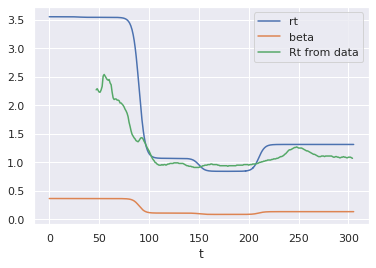

In [158]:
plt.figure()
history.rt.plot()
history.beta.plot()
plt.plot(train_t, train_subset.reproduction_rate, label='Rt from data')
plt.legend()
plt.show()

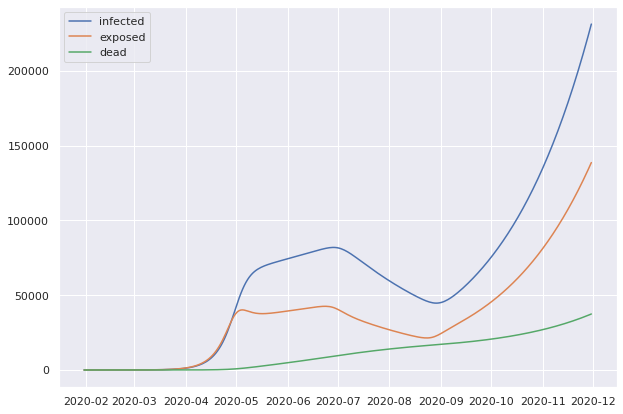

In [159]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, I, label='infected')
plt.plot(train_subset.date, E, label='exposed')
plt.plot(train_subset.date, D, label='dead')
plt.legend()
plt.show()

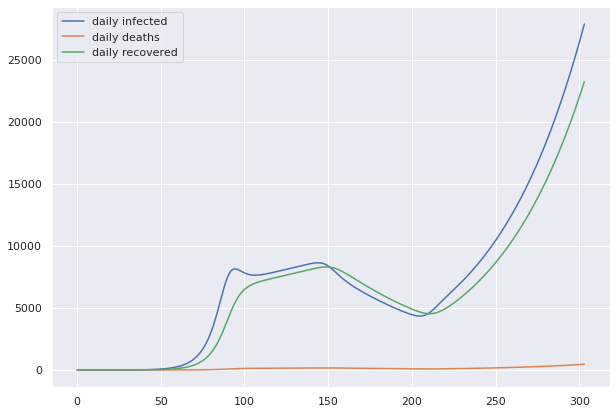

In [160]:
plt.figure(figsize=(10, 7))
plt.plot(new_infected, label='daily infected')
plt.plot(new_dead, label='daily deaths')
plt.plot(new_recovered, label='daily recovered')
plt.legend()
plt.show()

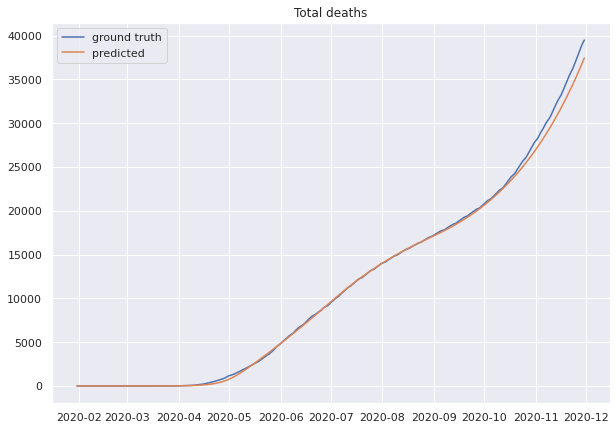

In [161]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_deaths'], label='ground truth')
plt.plot(train_subset.date, D, label='predicted')
plt.legend()
plt.title('Total deaths')
plt.show()

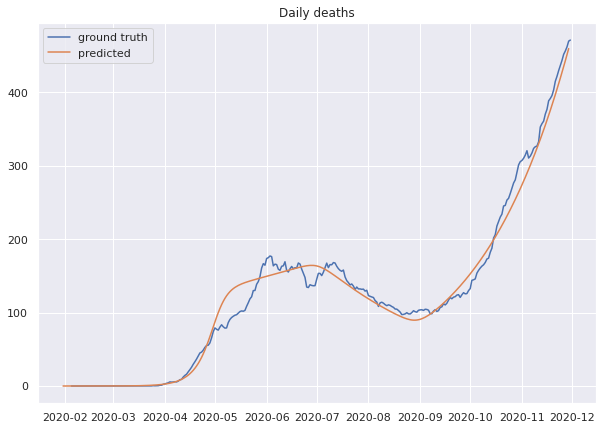

In [162]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['new_deaths_smoothed'], label='ground truth')
plt.plot(train_subset.date[:-1], new_dead, label='predicted')
plt.legend()
plt.title('Daily deaths')
plt.show()

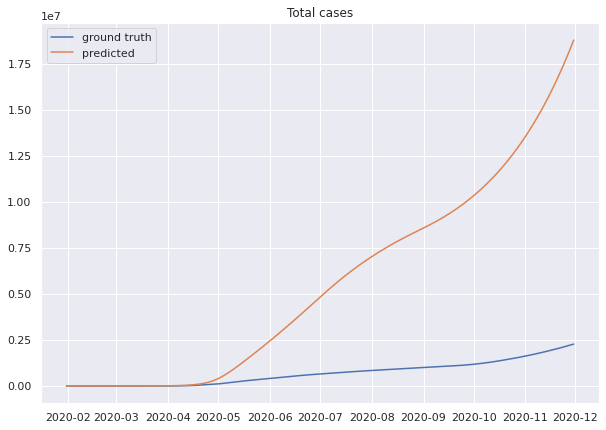

In [163]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_cases'], label='ground truth')
plt.plot(train_subset.date, I.cumsum(), label='predicted')
plt.legend()
plt.title('Total cases')
plt.show()

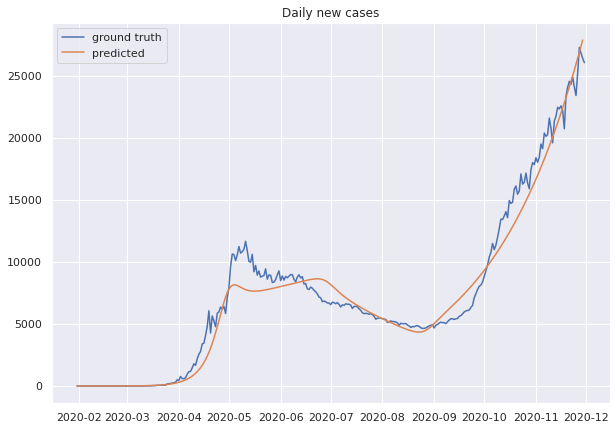

In [164]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['new_cases'], label='ground truth')
plt.plot(train_subset.date[:-1], new_infected, label='predicted')
plt.legend()
plt.title('Daily new cases')
plt.show()

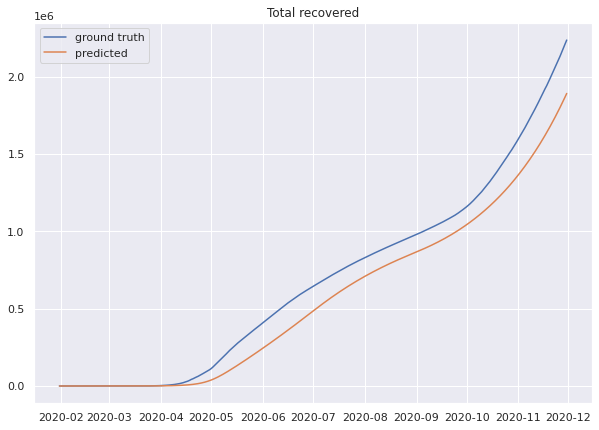

In [165]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset.total_cases - train_subset.total_deaths, label='ground truth')
plt.plot(train_subset.date, R, label='predicted')
plt.legend()
plt.title('Total recovered')
plt.show()

# Obtain forecast

In [166]:
test_t = len(train_subset) + np.arange(len(test_subset))

In [167]:
train_t, test_t

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [168]:
test_initial_conds = (S[-1], E[-1], I[-1], R[-1], D[-1])

In [169]:
(test_S, test_E, test_I, test_R, test_D), history = model.predict(test_t, test_initial_conds)

In [170]:
test_new_exposed, test_new_infected, test_new_recovered, test_new_dead = compute_daily_values(test_S, test_E, test_I, test_R, test_D)

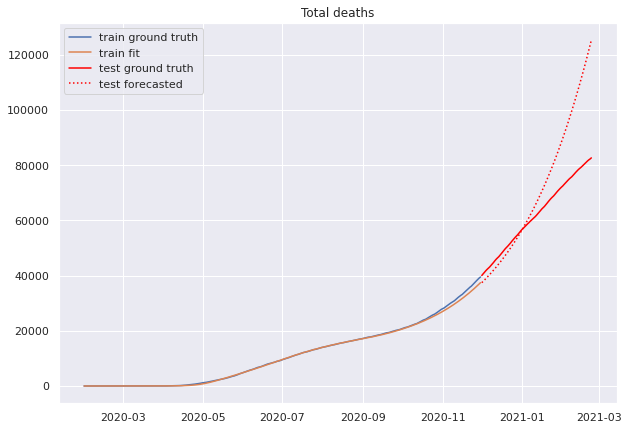

In [171]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_deaths'], label='train ground truth')
plt.plot(train_subset.date, D, label='train fit')

plt.plot(test_subset.date, test_subset['total_deaths'], label='test ground truth', color='red')
plt.plot(test_subset.date, test_D, label='test forecasted', color='red', linestyle=':')
plt.legend()
plt.title('Total deaths')
plt.show()

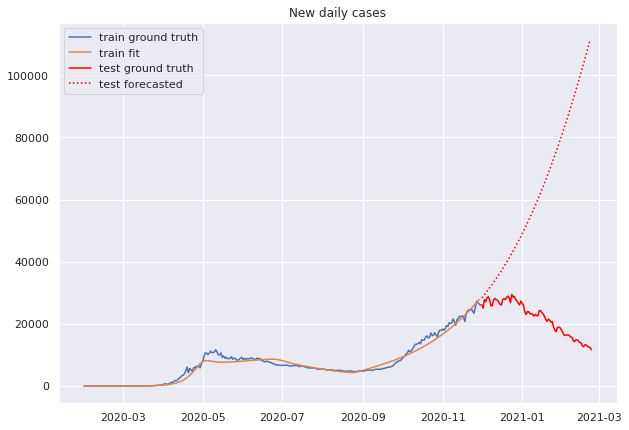

In [172]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['new_cases'], label='train ground truth')
plt.plot(train_subset.date[:-1], new_infected, label='train fit')

plt.plot(test_subset.date, test_subset['new_cases'], label='test ground truth', color='red')
plt.plot(test_subset.date[:-1], test_new_infected, label='test forecasted', color='red', linestyle=':')
plt.legend()
plt.title('New daily cases')
plt.show()

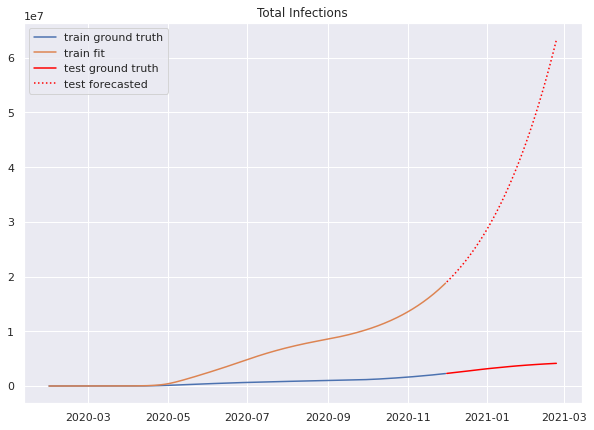

In [173]:
plt.figure(figsize=(10, 7))
plt.plot(train_subset.date, train_subset['total_cases'], label='train ground truth')
plt.plot(train_subset.date, I.cumsum(), label='train fit')

plt.plot(test_subset.date, test_subset['total_cases'], label='test ground truth', color='red')
plt.plot(test_subset.date, I.sum()+test_I.cumsum(), label='test forecasted', color='red', linestyle=':')
plt.legend()
plt.title('Total Infections')
plt.show()

# 1-day ahead evaluate

In [ ]:
eval_one_day_ahead(df, SEIR_OWID, CurveFitter, eval_period_start='2020-05-01', n_eval_points=10, total_dead_col='total_deaths', 
                   model_kwargs={'stepwise_size': 60}, fitter_kwargs={'verbose': True})